##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer Position Encoding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/position_encoding.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

See [this notebook](https://github.com/site/en/r2/tutorials/sequences/transformer.ipynb) for a walk-through of full transformer implementation.

The transformer architecture uses stacked attention layers in place of CNNs or RNNs. This makes it easy to learn long-range dependencise but it contains no built in information about the relative positions of items in a sequence. 

To give the model access to this information the transformer architecture uses adda a position encoding to the input.

This endocing is a vector of sines and cosines at each position, where each sine-cosine pair rotates at a different frequency.  

Nearby locations will have similar position-encoding vectors.

### Imports

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# import copy

The angle rates range from `1 [rads/step]` to `min_rate [rads/step]` over the vector depth.

Formula for angle rate:

$$angle\_rate_d = (min\_rate)^{d / d_{max}} $$

In [3]:
# num_positions = 50
# depth = 512
# min_rate = 1/10000

# assert depth%2 == 0, "Depth must be even."
# angle_rate_exponents = np.linspace(0,1,depth//2)
# angle_rates = min_rate**(angle_rate_exponents)

In [4]:
# angle_rate_exponents.shape

The resulting exponent goes from `0` to `1`, causing the `angle_rates` to drop exponentially from `1` to `min_rate`.

In [5]:
# plt.semilogy(angle_rates)
# plt.xlabel('Depth')
# plt.ylabel('Angle rate [rads/step]')

Broadcasting a multiply over angle rates and positions gives a map of the position encoding angles as a function of depth.

In [6]:
# positions = np.arange(num_positions) 
# angle_rads = (positions[:, np.newaxis])*angle_rates[np.newaxis, :]

In [7]:
# print(positions.shape)
# print(angle_rates.shape)
# print("angle_rads shape = ", angle_rads.shape)

In [8]:
# print(angle_rads[0, 0:5])
# print(angle_rads[1, 0:5])
# print(angle_rads[2, 0:5])
# print(angle_rads[10, 0:5])

In [9]:
# plt.figure(figsize = (14,8))
# plt.pcolormesh(
#     # Convert to degrees, and wrap around at 360
#     angle_rads*180/(2*np.pi) % 360,
#     # Use a cyclical colormap so that color(0) == color(360)
#     cmap='hsv', vmin=0, vmax=360)

# plt.xlim([0,len(angle_rates)])
# plt.ylabel('Position')
# plt.xlabel('Depth')
# bar = plt.colorbar(label='Angle [deg]')
# bar.set_ticks(np.linspace(0,360,6+1))

### Plot A Number Of Positional Vectors

In [10]:
# listInd = [0, 1, 4, 10, 20, 30, 45]
# fig, axs = plt.subplots(2, len(listInd), figsize=(20, 5))
# ### Plot rads
# for i in range(len(listInd)):
#     axs[0, i].plot(angle_rads[listInd[i], :])
# ### Plot degrees
# angle_degrees = angle_rads * 180 / (2*np.pi) % 360
# for i in range(len(listInd)):
#     axs[1, i].plot(angle_degrees[listInd[i], :])
# plt.show()

Raw angles are not a good model input (they're either unbounded, or discontinuous). So take the sine and cosine:

In [11]:
# sines = np.sin(angle_rads)
# cosines = np.cos(angle_rads)
# pos_encoding = np.concatenate([sines, cosines], axis=-1)

In [12]:
# plt.figure(figsize=(14,8))
# plt.pcolormesh(pos_encoding, 
#                # Use a diverging colormap so it's clear where zero is.
#                cmap='RdBu', vmin=-1, vmax=1)
# plt.xlim([0,depth])
# plt.ylabel('Position')
# plt.xlabel('Depth')
# plt.colorbar()
# plt.show()

### Nearby positions

Nearby locations will have similar position-encoding vectors. 

To demonstrate compare one position's encoding (here position 20) with each of the others:

In [13]:
# pos_encoding_at_20 = pos_encoding[20]

# dots = np.dot(pos_encoding,pos_encoding_at_20)
# SSE = np.sum((pos_encoding - pos_encoding_at_20)**2, axis=1)

Regardless of how you compare the vecors, they are most similar 20, and clearly diverge as you move away: 

In [14]:
# plt.figure(figsize=(10,8))
# plt.subplot(2,1,1)
# plt.plot(dots)
# plt.ylabel('Dot product')
# plt.subplot(2,1,2)
# plt.plot(SSE)
# plt.ylabel('SSE')
# plt.xlabel('Position')

### Relative positions

The [paper](https://arxiv.org/pdf/1706.03762.pdf) explains, at the end of section 3.5, that any relative position encoding can be written as a linear function of the current position.

To demonstrate, this section builds a matrix that calculates these relative position encodings. 

In [15]:
# def transition_matrix(position_delta, angle_rates = angle_rates):
#   # Implement as a matrix multiply:
#   #    sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
#   #    cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
  
#   # b
#   angle_delta = position_delta*angle_rates

#   # sin(b), cos(b)
#   sin_delta = np.sin(angle_delta)
#   cos_delta = np.cos(angle_delta)

#   I = np.eye(len(angle_rates))
  
#   # sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
#   update_sin = np.concatenate([I*cos_delta, I*sin_delta], axis=0)
  
#   # cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
#   update_cos = np.concatenate([-I*sin_delta, I*cos_delta], axis=0)

#   return np.concatenate([update_sin, update_cos], axis=-1)

For example, create the matrix that calculates the position encoding 10 steps back, from the current position encoding:

In [16]:
# position_delta = -10
# update = transition_matrix(position_delta)

Applying this matrix to each position encoding vector gives position encoding vector from -10 steps away, resulting in a shifted position-encoding map:

In [17]:
# plt.figure(figsize=(14,8))
# plt.pcolormesh(np.dot(pos_encoding,update), cmap='RdBu', vmin=-1, vmax=1)
# plt.xlim([0,depth])
# plt.ylabel('Position')
# plt.xlabel('Depth')

This is accurate to numerical precision.

In [18]:
# errors = np.dot(pos_encoding,update)[10:] - pos_encoding[:-10]
# abs(errors).max()

# Do The Same Using Time Stamps Instead Of Positions

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import copy

### A First Test With positions Being Real Numbers Rather Then Integers

In [20]:
num_positions = 16
depth = 512
min_rate = 1/10000

assert depth%2 == 0, "Depth must be even."
angle_rate_exponents = np.linspace(0,1,depth//2)
angle_rates = min_rate**(angle_rate_exponents)

In [21]:
print("angle_rates shape = ", angle_rates.shape)

angle_rates shape =  (256,)


In [22]:
positions = np.arange(num_positions) 
angle_rads = (positions[:, np.newaxis])*angle_rates[np.newaxis, :]

In [23]:
fracPositions = positions*10/10
print(positions.shape)
print("")
print(positions[0:5])
print(fracPositions[0:5])

(16,)

[0 1 2 3 4]
[0. 1. 2. 3. 4.]


In [24]:
angle_rads = fracPositions[:, np.newaxis]*angle_rates[np.newaxis, :]

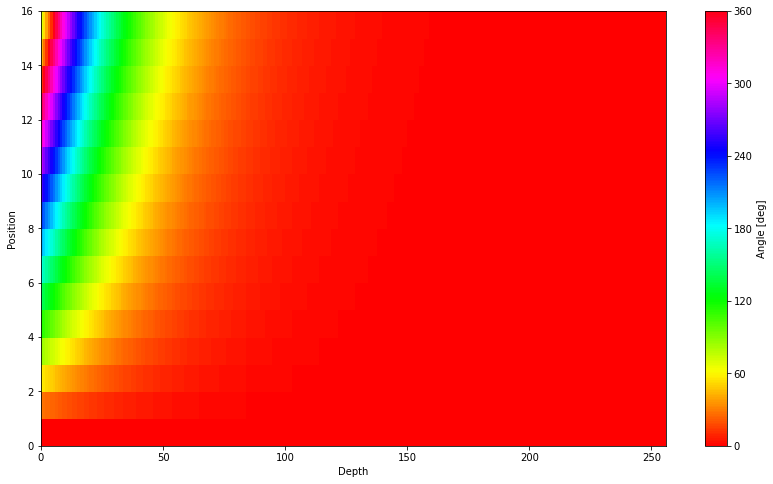

In [25]:
plt.figure(figsize = (14,8))
plt.pcolormesh(
    # Convert to degrees, and wrap around at 360
    angle_rads*180/(2*np.pi) % 360,
    # Use a cyclical colormap so that color(0) == color(360)
    cmap='hsv', vmin=0, vmax=360)

plt.xlim([0,len(angle_rates)])
plt.ylabel('Position')
plt.xlabel('Depth')
bar = plt.colorbar(label='Angle [deg]')
bar.set_ticks(np.linspace(0,360,6+1))

In [26]:
sines = np.sin(angle_rads)
cosines = np.cos(angle_rads)
pos_encoding = np.concatenate([sines, cosines], axis=-1)

### Merge sines and cosines  properly, not with concatenate.
example = np.reshape(np.vstack((sines, cosines)).ravel('F'), (num_positions, depth), order='F')

In [27]:
print(sines[11, 0:5])
print(cosines[11, 0:5])
print("")
print(example[11, 0:10])

[-0.99999021 -0.92650013 -0.72333941 -0.43100098 -0.09531036]
[ 0.0044257  -0.37629444 -0.69049265 -0.90235146 -0.99544761]

[-0.99999021  0.0044257  -0.92650013 -0.37629444 -0.72333941 -0.69049265
 -0.43100098 -0.90235146 -0.09531036 -0.99544761]


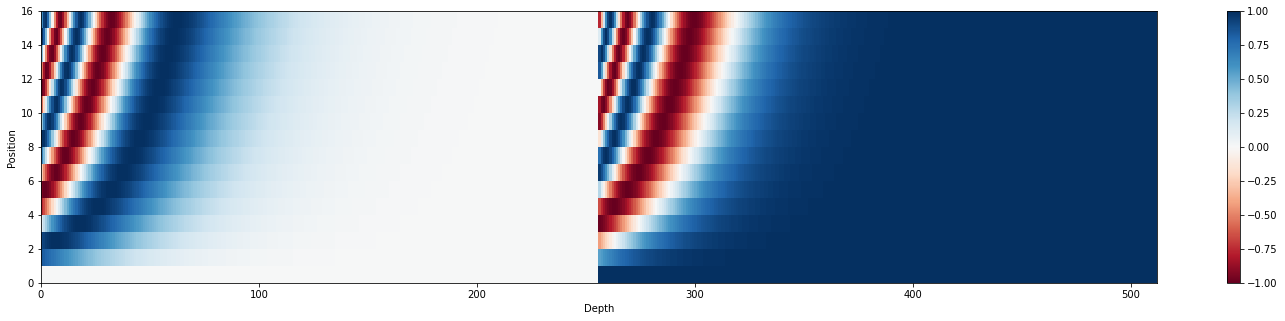

In [28]:
plt.figure(figsize=(25,5))
plt.pcolormesh(pos_encoding, 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()

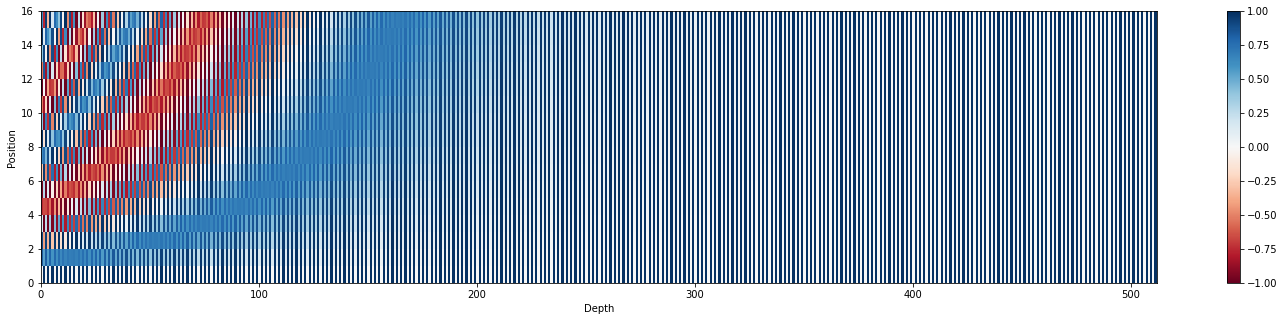

In [29]:
plt.figure(figsize=(25,5))
plt.pcolormesh(example, 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()

# Generate Input Data For The Experimental Model

Idea to treat the fact that the input sequence has fixed size (sequence goes beyond sentence boundary).  
When the next sentence starts, the begin and end time stamps for each word are summed up with the end time stamp of the last word of the previous sentence.

### Process The Input Data In Order To Implement The Idea Written Above

### Start Working Only On One Sequence

In [30]:
# ### Get The Values For The First Sequence

# nameInpFile = "outFile_01.txt"
# nameOutFile = "outFile_02.txt"
# sequenceSize = 18
# words = []
# punctuations = []
# wordsBegin = []
# wordsEnd = []
# with open(nameInpFile, "r") as inpFile:
#     lines = inpFile.readlines()
#     for i in range(sequenceSize):
#         items = lines[i].split("\t")
#         words.append(items[0])
#         punctuations.append(items[1])
#         wordsBegin.append(float(items[2]))
#         wordsEnd.append(float(items[3]))
# print(words)

In [31]:
# ### Apply The Correction To The Time Stamp

# wordsBeginCorr = np.asarray(copy.deepcopy(wordsBegin))
# wordsEndCorr = np.asarray(copy.deepcopy(wordsEnd))
# for i in range(sequenceSize-1):
#     wordEnd = wordsEnd[i]
#     nextWordBegin = wordsBegin[i+1]
#     # I add an additional condition because sometimes wordEnd > nextWordBegin
#     # but not beacause of the start of a new sentence.
#     if wordEnd > nextWordBegin and abs(wordEnd - nextWordBegin) > 0.02:
#         # print(i)
#         wordsBeginCorr[i+1:] += wordEnd
#         wordsEndCorr[i+1:] += wordEnd

In [32]:
# ### Output The Corrected File

# with open(nameOutFile, "w") as outFile:
#     for i in range(sequenceSize):
#         outFile.write(words[i] + "\t" + punctuations[i] + "\t" + str(wordsBeginCorr[i]) + "\t" + str(wordsEndCorr[i]) + "\n")

### Work On The Entire Dataset

In [33]:
# ### Get The Values For Each Sequence, Do Not Apply Corrections, Write The Output, Loop On The All Dataset

# nameInpFile = "outFile_01.txt"
# nameOutFile = "outFile_02.txt"
# sequenceSize = 32

# with open(nameInpFile, "r") as inpFile:
#     lines = inpFile.readlines()
# numLine = len(lines)

# # get the bound for the loop
# rest = numLine - sequenceSize * (numLine//sequenceSize)
# bound = numLine - rest - sequenceSize

# dataWords = []
# dataPuncs = []
# dataBegins = []
# dataEnds = []

# count = 0  # index for the rows in input file
# while count < numLine:
    
#     sequenceWords = []
#     sequencePuncs = []
#     sequenceBegins = []
#     sequenceEnds = []
    
#     ### get the values for a sequence
#     tmp = 0  # this to count the effective size of the sequence
#     if count <= bound:
#         for i in range(sequenceSize):
#             tmp += 1
#             items = lines[count+i].split("\t")
#             sequenceWords.append(items[0])
#             sequencePuncs.append(items[1])
#             sequenceBegins.append(float(items[2]))
#             sequenceEnds.append(float(items[3]))
#     else:
#         for i in range(bound+sequenceSize, numLine):
#             tmp += 1
#             items = lines[i].split("\t")
#             sequenceWords.append(items[0])
#             sequencePuncs.append(items[1])
#             sequenceBegins.append(float(items[2]))
#             sequenceEnds.append(float(items[3]))
#     # print("count = ", count)
#     # print("tmp = ", tmp)
#     count += sequenceSize

# #     ### Note that these two corrections are now implemented directly in 
# #     ### the training script.
# #     ### CORRECTION 1
# #     ### apply the correction to the time stamp
# #     sequenceBeginsCorr = np.asarray(copy.deepcopy(sequenceBegins))
# #     sequenceEndsCorr = np.asarray(copy.deepcopy(sequenceEnds))
# #     for i in range(tmp-1):
# #         wordEnd = sequenceEnds[i]
# #         nextWordBegin = sequenceBegins[i+1]
# #         ### i add an additional condition because sometimes wordEnd > nextWordBegin
# #         ### but not beacause of the start of a new sentence.
# #         if wordEnd > nextWordBegin and abs(wordEnd - nextWordBegin) > 0.01:
# #             sequenceBeginsCorr[i+1:] += wordEnd
# #             sequenceEndsCorr[i+1:] += wordEnd
# # #         ### same as before but without the additional condition
# # #         if wordEnd > nextWordBegin:
# # #             sequenceBeginsCorr[i+1:] += wordEnd
# # #             sequenceEndsCorr[i+1:] += wordEnd
# #     ### CORRECTION 2
# #     ### add an additional correction
# #     ### set beginning of first word in the sentence as time zero.
# #     sequenceBeginsCorr[:] -= sequenceBegins[0]
# #     sequenceEndsCorr[:] -= sequenceBegins[0]
    
    
#     ### collect the corrected values
#     dataWords += sequenceWords
#     dataPuncs += sequencePuncs
#     ### As said above, the corrections are now applied in the
#     ### training script, so i use the not corrected sequences.
#     # dataBegins += list(sequenceBeginsCorr)
#     # dataEnds += list(sequenceEndsCorr)
#     dataBegins += list(sequenceBegins)
#     dataEnds += list(sequenceEnds)

# ### Output The Corrected File
# with open(nameOutFile, "w") as outFile:
#     for i in range(numLine):
#         outFile.write(dataWords[i] + "\t" + dataPuncs[i] + "\t" + str(dataBegins[i]) + "\t" + str(dataEnds[i]) + "\n")

In [34]:
### As Above, But Do Apply The Corrections

nameInpFile = "outFile_01.txt"
nameOutFile = "outFile_02.txt"
sequenceSize = 32

with open(nameInpFile, "r") as inpFile:
    lines = inpFile.readlines()
numLine = len(lines)

# get the bound for the loop
rest = numLine - sequenceSize * (numLine//sequenceSize)
bound = numLine - rest - sequenceSize

dataWords = []
dataPuncs = []
dataBegins = []
dataEnds = []

count = 0  # index for the rows in input file
while count < numLine:
    
    sequenceWords = []
    sequencePuncs = []
    sequenceBegins = []
    sequenceEnds = []
    
    ### get the values for a sequence
    tmp = 0  # this to count the effective size of the sequence
    if count <= bound:
        for i in range(sequenceSize):
            tmp += 1
            items = lines[count+i].split("\t")
            sequenceWords.append(items[0])
            sequencePuncs.append(items[1])
            sequenceBegins.append(float(items[2]))
            sequenceEnds.append(float(items[3]))
    else:
        for i in range(bound+sequenceSize, numLine):
            tmp += 1
            items = lines[i].split("\t")
            sequenceWords.append(items[0])
            sequencePuncs.append(items[1])
            sequenceBegins.append(float(items[2]))
            sequenceEnds.append(float(items[3]))
    # print("count = ", count)
    # print("tmp = ", tmp)
    count += sequenceSize

    ### CORRECTION 1
    ### apply the correction to the time stamp
    sequenceBeginsCorr = np.asarray(copy.deepcopy(sequenceBegins))
    sequenceEndsCorr = np.asarray(copy.deepcopy(sequenceEnds))
    for i in range(tmp-1):
        wordEnd = sequenceEnds[i]
        nextWordBegin = sequenceBegins[i+1]
        ### i add an additional condition because sometimes wordEnd > nextWordBegin
        ### but not beacause of the start of a new sentence.
        if wordEnd > nextWordBegin and abs(wordEnd - nextWordBegin) > 0.021:
            sequenceBeginsCorr[i+1:] += wordEnd
            sequenceEndsCorr[i+1:] += wordEnd
#         ### same as before but without the additional condition
#         if wordEnd > nextWordBegin:
#             sequenceBeginsCorr[i+1:] += wordEnd
#             sequenceEndsCorr[i+1:] += wordEnd
    ### CORRECTION 2
    ### add an additional correction
    ### set beginning of first word in the sentence as time zero.
    sequenceBeginsCorr[:] -= sequenceBegins[0]
    sequenceEndsCorr[:] -= sequenceBegins[0]
    
    ### collect the corrected values
    dataWords += sequenceWords
    dataPuncs += sequencePuncs
    dataBegins += list(sequenceBeginsCorr)
    dataEnds += list(sequenceEndsCorr)

### Output The Corrected File
with open(nameOutFile, "w") as outFile:
    for i in range(numLine):
        outFile.write(dataWords[i] + "\t" + dataPuncs[i] + "\t" + str(dataBegins[i]) + "\t" + str(dataEnds[i]) + "\n")

In [35]:
### Check The Output File
### endTimeWord > startTimeNextWord only in case the two words belongs to different sequences.

lineIndexList = []
with open(nameOutFile, "r") as f:
    lines = f.readlines()
numLines = len(lines)
for i in range(numLines-1):
    items = lines[i].split("\t")
    nextItems = lines[i+1].split("\t")
    endTimeWord = float(items[3])
    startTimeNextWord = float(nextItems[2])
    if endTimeWord > startTimeNextWord:
        lineIndex = i+1
        if (lineIndex % sequenceSize) == 0:
            continue
        else:
            lineIndexList.append(lineIndex)
print("Number of issues = ", len(lineIndexList))

Number of issues =  37100


In [36]:
### Obtain another output file where there is only SPACE and PERIOD.

nameInpFile = "outFile_02.txt"
nameOutFile = "outFile_03.txt"
with open(nameInpFile, 'r') as inpFile:
    lines = inpFile.readlines()
with open(nameOutFile, 'w') as outFile:
    numLines = len(lines)
    for line in lines:
        items = line.split("\t")
        if items[1] == "COMMA" or items[1] == "SEMICOLON" or items[1] == "COLON" or items[1] == "EXCLAMATION" or items[1] == "QUESTION":
            items[1] = "PERIOD"
        outFile.write(items[0] + "\t" + items[1] + "\t" + items[2]+ "\t" + items[3])